# *Overfit* y *underfit*

## Objetivos
- Comprender qué son y por qué se producen fenómenos como el sobreajuste u *overfitting* y el subajuste o *underfitting*.
- Conocer diferentes técnicas que favorecen que nuestro modelo generalice mejor.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import numpy as np
import pandas as pd
from IPython import display
from matplotlib import pyplot as plt

import os

print(tf.__version__)

2.18.0


## Base de datos de IMDB con reseñas de películas

La base de datos de IMDB se utiliza principalmente en el área de procesamiento de lenguaje natural ya que contiene 50000 reseñas de usuarios sobre películas. El objetivo es entrenar un modelo que sea capaz de determinar si la reseña es positiva o negativa. Por tanto, se trata de un problema de clasificación.

La base de datos IMDB es una de las más populares en el ámbito del *deep learning* y está disponible en [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).

Aunque en ingeniería química los datos que se manejan suelen ser de tipo numérico, esta base de datos textual es muy ilustrativa para profundizar en conceptos como el *overfitting* y el *underfitting*.

In [2]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (val_data, val_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
X_train = vectorize_sequences(train_data)
# Our vectorized test data
X_valid = vectorize_sequences(val_data)
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_valid = np.asarray(val_labels).astype('float32')

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Demostrar *overfiting* y *underfiting*
En esta sección vamos a entrenar diferentes configuraciones o arquitecturas de redes neuronales siguiendo el mismo procedimiento de entrenamiento para poder comparar las diferencias entre ellas.

### Definir los modelos

La capacidad de un modelo se refiere al tamaño y la complejidad de los patrones que es capaz de aprender. En el caso de las redes neuronales, depende del número de neuronas que tenga y de cómo estén conectadas entre sí. Por tanto, si parece que una red no se ajusta bien a los datos, se debe aumentar su capacidad.

Hay dos maneras de aumentar la capacidad de una red neuronal:
- Haciendo la red más ancha (añadiendo más neuronas a las capas existentes).
- Haciendo la red más profunda (añadiendo más capas).

A las redes más anchas les resulta más fácil aprender relaciones  lineales, mientras que las redes más profundas prefieren las no lineales.

Primero, construye un modelo lineal que sirva como referencia. En los problemas de clasificación, sí que se aplica una función de activación de tipo sigmoide en la *output layer*, pues ayuda a restringir los valores de salida entre 0 (valoración negativa) y 1 (valoración positiva).

<img src=https://miro.medium.com/v2/resize:fit:640/format:webp/1*jSCPkJo0ZpBRA5H3JqFhQg.png width="300">

In [4]:
linear = keras.Sequential(
    [
        layers.Input(shape=[X_train.shape[1]]),
        layers.Dense(1, activation='sigmoid')
    ]
)

El siguiente modelo será una red neuronal con una única capa oculta de 5 neuronas y función de activación ReLU.

In [5]:
small = keras.Sequential(
    [
        layers.Input(shape=[X_train.shape[1]]),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

Por comparación, crea una red neuronal que sea más "ancha" que la anterior. Por ejemplo, incrementa el número de neuronas a 32.

In [6]:
wider = keras.Sequential(
    [
        layers.Input(shape=[X_train.shape[1]]),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

Finalmente, crea una red que sea más profuda, doblando el número de capas ocultas con respecto al modelo `small`.

In [7]:
deeper = keras.Sequential(
    [
        layers.Input(shape=[X_train.shape[1]]),
        layers.Dense(5, activation='relu'),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

### Establecer un método de entrenamiento común

Como se va a emplear la misma configuración para los comandos `compile` y `fit` y, además, se va a aplicar a los diferentes modelos, resulta conveniente agrupar todo este proceso en una función que llamaremos `compile_and_fit`.

In [8]:
N_TRAIN = len(y_train)
BATCH_SIZE = 512
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
EPOCHS = 20

In [9]:
def compile_and_fit(model, callback , max_epochs=EPOCHS):

  model.compile(optimizer='rmsprop',
                loss='binary_crossentropy',
                metrics=['accuracy'])

  history = model.fit(
                      X_train , # Completa con las inputs de entrenamiento
                      y_train , # Completa con las outputs de entrenamiento
                      validation_data= (X_valid, y_valid) , # Completa con los datos de validación en forma de tupla (X,y)
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callback, # put your callbacks in a list
                      verbose=0,  # turn off training log
                      )

  return history

### Comparar el proceso de entrenamiento

In [12]:
#size_histories = {}
#size_histories['linear'] = compile_and_fit(linear, [])
#size_histories['small'] = compile_and_fit(small, [])
#size_histories['wider'] = compile_and_fit(wider, [])
size_histories['deeper'] = compile_and_fit(deeper, [])

In [13]:
print("Minimum validation loss:")
for model_name, history in size_histories.items():
    print("    - "+model_name+": "+str(min(history.history['val_loss'])))

Minimum validation loss:
    - linear: 0.27895495295524597
    - small: 0.2779256999492645
    - wider: 0.27837592363357544
    - deeper: 0.5847739577293396


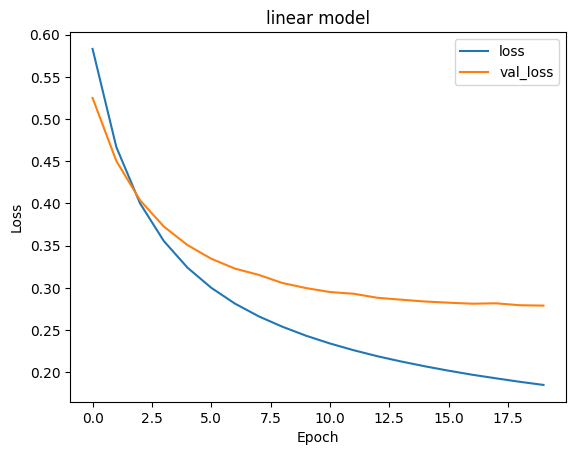

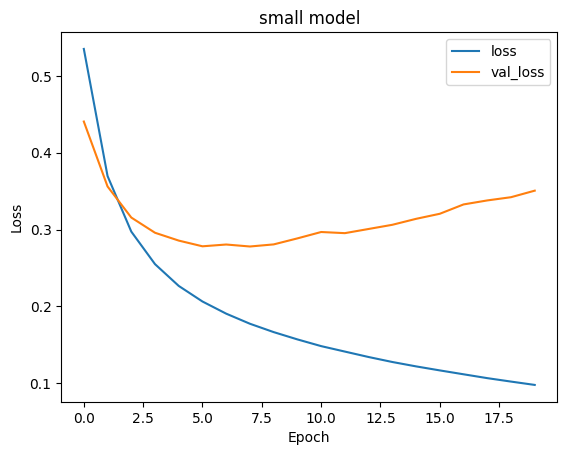

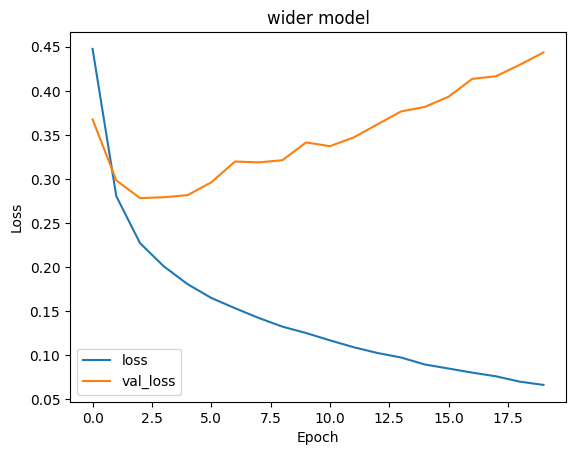

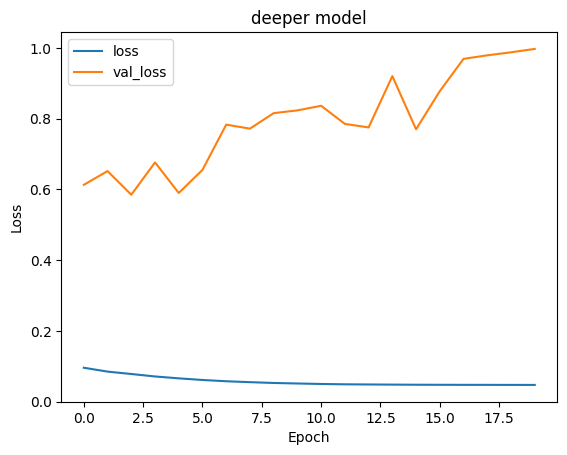

In [14]:
def plot_history(model_name, history, ylim=None):
    history_df = pd.DataFrame(history.history)
    history_df.loc[:, ['loss', 'val_loss']].plot()
    plt.title(model_name+' model')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    if ylim is not None:
        plt.ylim(ylim)

plot_history('linear', size_histories['linear'],)
plot_history('small', size_histories['small'],)
plot_history('wider', size_histories['wider'],)
plot_history('deeper', size_histories['deeper'], )

## Técnicas para prevenir el sobreajuste

#### *Early stopping*

Hemos visto que los modelos tienden a aprender inclus el ruido que hay en los datos tratando de ajustarse lo máximo posible a los datos de entrenamiento. Cuando esto ocurre, la *loss function* medida en el set de validación puede comienza a aumentar.

Para evitarlo, podemos detener el entrenamiento cuando parezca que la pérdida de validación ya no disminuye. Interrumpir el entrenamiento de esta forma se denomina *early stopping* y en TensorFlow se implementa por medio de un *callback*.

Los *callback* son simplemente una función que se ejecutan cada cierto tiempo mientras la red se entrena. El *early stopping* lo hace después de cada época. Tensorflow cuenta con una [variedad de callbacks útiles predefinidos](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks), pero también pueden definirse de forma personalizada.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor = 'val_loss' , # Magnitud que se va a "vigilar"
    min_delta= 0.001 , # Mínimo cambio para considerar como mejora
    patience= 1 , # Épocas que esperamos para parar cuando se deja de mejorar
    restore_best_weights=True,
)

model = keras.Sequential(
    [
        layers.Input(shape=[X_train.shape[1]]),
        layers.Dense(5, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
) #(elige el modelo small)

history = compile_and_fit(model, [early_stopping])

Minimum validation loss:
    - Early stopping model: 0.27829161286354065


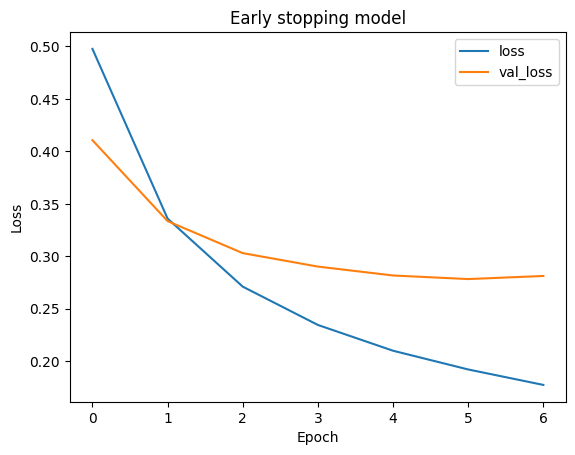

In [17]:
print("Minimum validation loss:")
print("    - Early stopping model: "+str(min(history.history['val_loss'])))

plot_history('Early stopping', history)

#### Regularización
Una forma común de mitigar el sobreajuste es forzando a que los pesos tomen valores pequeños. Esto se llama **regularización** y se hace añadiendo a la *loss function* de la red un coste asociado a tener pesos grandes. Este coste puede ser de dos tipos:

* [Regularización L1](https://developers.google.com/machine-learning/glossary/#L1_regularization), donde el coste añadido es proporcional al valor absoluto de los coeficientes de los pesos (es decir, a lo que se denomina la «norma L1» de los pesos).

* [Regularización L2](https://developers.google.com/machine-learning/glossary/#L2_regularization), en la que el coste añadido es proporcional al cuadrado del valor de los coeficientes de las ponderaciones (es decir, a lo que se denomina la «norma L2» al cuadrado de los pesos).

La regularización L1 fomenta que los pesos tomen el valor de 0 exactamente mientras que la regularización L2 penalizará los parámetros de pesos sin hacerlos totalmente 0, ya que la penalización va a cero para pesos pequeños. Es por esto que la L2 es más común en el contexto de redes neuronales, ya que favorece el aprendizaje al reducir el riesgo de *vanishing gradients*.

In [18]:
l2_model = keras.Sequential([
        layers.Input(shape=[X_train.shape[1]]),
        layers.Dense(5, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
        layers.Dense(1, activation='sigmoid')
])

history = compile_and_fit(l2_model, [early_stopping])

Minimum validation loss:
    - L2-Reg model: 0.32122981548309326


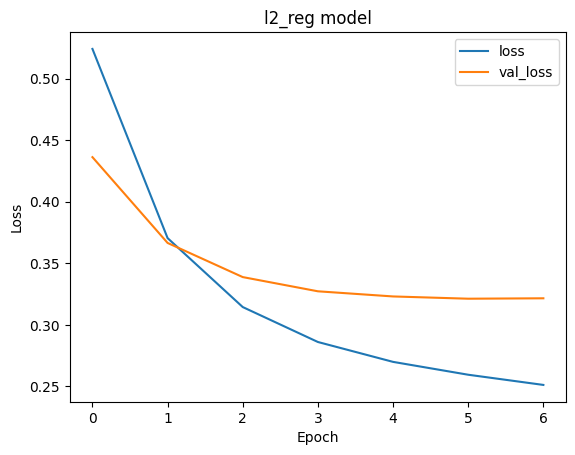

In [19]:
print("Minimum validation loss:")
print("    - L2-Reg model: "+str(min(history.history['val_loss'])))

plot_history('l2_reg',history)

#### Dropout
El *dropout* es una de las técnicas de regularización de redes neuronales más eficaces y utilizadas, que consiste en «descartar» aleatoriamente una serie de características de salida de la capa durante el entrenamiento. Por ejemplo, una capa determinada habría devuelto normalmente un vector `[0,2, 0,5, 1,3, 0,8, 1,1]` para una muestra de entrada determinada durante el entrenamiento; después de aplicar el dropout, este vector tendrá unas cuantas entradas cero distribuidas al azar, por ejemplo `[0, 0,5, 1,3, 0, 1,1]`.

El *dropout rate* es la fracción de las características que se eliminan; normalmente se fija entre 0,2 y 0,5.

En TensorFlow, puedes introducir el abandono en una red a través de la capa `tf.keras.layers.Dropout`, que se aplica a la salida de la capa justo antes.

In [21]:
dropout_model = keras.Sequential([
        layers.Input(shape=[X_train.shape[1]]),
        layers.Dense(5, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
])

history = compile_and_fit(dropout_model, [])

Minimum validation loss:
    - Dropout model: 0.2773546278476715


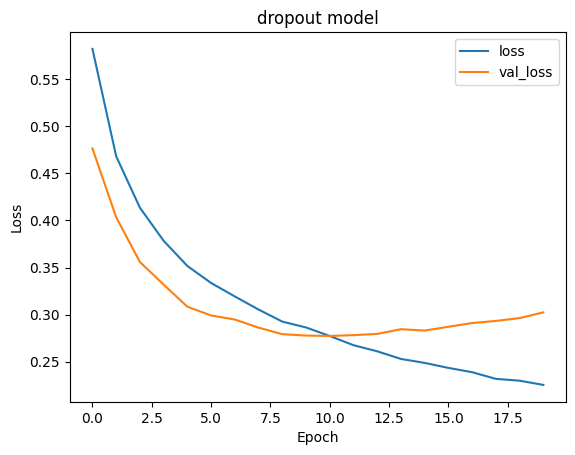

In [22]:
print("Minimum validation loss:")
print("    - Dropout model: "+str(min(history.history['val_loss'])))

plot_history('dropout',history)

## Conlcusiones
Para recapitular, éstas son las formas más comunes de evitar el sobreajuste en las redes neuronales:

* Obtener más datos de entrenamiento.
* Reducir la capacidad de la red.
* Añadir regularización de pesos.
* Añadir abandono.